In [11]:
import svetlanna as sv
from svetlanna.units import ureg
import torch
import tqdm
from svetlanna.detector import Detector
from svetlanna.simulation_parameters import SimulationParameters
from collections import deque
from typing import Sequence, TypeVar
import matplotlib.pyplot as plt

# Mackey-Glass

The Mackey-Glass equation (DOI: 10.1126/science.267326, 4b) is given by:
$$
\frac{dx}{dt} = \frac{\beta \theta^n x(t-\tau)}{\theta^n + x^n(t-\tau)} - \gamma x(t)
$$
In discrete form:
$$
x[t+1] = \frac{\beta \theta^n x[t-\tau]}{\theta^n + x^n[t-\tau]} - \gamma x[t]
$$

In [5]:
T = TypeVar('T', bound=float)

def mackey_glass_generator(
    x0: Sequence[T],
    n: float,
    beta: float,
    gamma: float,
    theta: float
):
    queue: deque[T] = deque(x0)

    while True:
        x = queue.popleft()
        x_prev = queue[-1]
        new_x = beta * theta**n * x / (theta**n + x**n) - gamma * x_prev

        queue.append(new_x)
        yield new_x

# Reservoir

A simple reservoir model (the main idea is explained in https://doi.org/10.1364/OE.20.022783):
$$
    x_{out}[i] = F_{NL}(\beta x_{in}[i] + \alpha F_{D}(x_{out}[i-\tau]))
$$
where $x_{in}$ is the input signal, $\tau$ is the time delay, $F_{NL}$ is the nonlinear element, $F_{D}$ is the delay element, $\alpha$ is the input gain, and $\beta$ is the feedback gain.

In this example, $F_{NL}$ is a diffractive layer with a random mask, and $F_{D}$ consists of nonlinear element with a nonlinear amplitude response
$$
|\vec{E}_{out}|=\dfrac{|\vec{E}_{in}|^2}{1 + |\vec{E}_{in}|^2}
$$
and free space.

In [ ]:
L = 1 * ureg.cm  # size of the simulation domain
N = 5  # mesh size


sim_params = sv.SimulationParameters(
    {
        'W': torch.linspace(-L/2, L/2, N),
        'H': torch.linspace(-L/2, L/2, N),
        'wavelength': 1 * ureg.um
    }
)

# Diffractive layer
difflayer = sv.elements.DiffractiveLayer(
    sim_params,
    mask=torch.rand((N, N)),
    mask_norm=1
)

# Element with nonlinear response
nonlinear_element = sv.elements.NonlinearElement(
    simulation_parameters=sim_params,
    response_function=lambda x: x**2 / (1 + x**2)
)

# Free space
fs = sv.elements.FreeSpace(
    sim_params,
    distance=2 * ureg.cm,
    method='AS'
)

# The reservoir system
reservoir = sv.elements.SimpleReservoir(
    sim_params,
    nonlinear_element=difflayer,
    delay_element=sv.LinearOpticalSetup(
        [nonlinear_element, fs]
    ),
    feedback_gain=0.8,
    input_gain=1.,
    delay=10
)

# Detector
detector = Detector(
    sim_params
)

To enable masking of the input signal, one should create a custom module that applies masking in the forward method and then calculates the average of the detector output over a single symbol.

In [27]:
class ReservoirSystem(torch.nn.Module):
    def __init__(
        self,
        simulation_parameters: SimulationParameters,
        reservoir: sv.elements.SimpleReservoir,
        detector: sv.elements.Element,
        mask: torch.Tensor
    ):
        super().__init__()

        assert len(mask.shape) == 1

        self.mask = mask
        self.simulation_parameters = simulation_parameters
        self.reservoir = reservoir
        self.detector = detector

    def forward(self, x) -> torch.Tensor:

        # before new sequence one should drop the wavefronts
        # stored in the feedback line
        self.reservoir.drop_feedback_queue()

        res = torch.empty(
            (
                x.shape[0],
                self.simulation_parameters.axes_size('W')[0] * self.simulation_parameters.axes_size('H')[0]
            )
        )
        mask_size = self.mask.shape[0]

        # For each symbol in the sequence
        for i, u in enumerate(x):
            masked_input = u * self.mask

            detector_signal = 0
            # For each mask frame in the mask
            for u_masked in masked_input:
                # Encode the signal in the amplitude of incident field
                wf = u_masked * sv.Wavefront.gaussian_beam(
                    self.simulation_parameters,
                    waist_radius=0.2 * ureg.cm
                )
                # Calculate the propagation through the reservoir
                wf = self.reservoir(wf)
                detector_signal += self.detector(wf)

            # Calculate average signal on the detector during the symbol
            # The output of this module is a vector of real value
            res[i] = detector_signal.ravel() / mask_size

        return res

# Dataset

In [ ]:
MG_TRAIN_SIZE = 200

MG_X_PREHEAT_NUM = 100  # Number of preheat symbols
MG_X_NUM = MG_X_PREHEAT_NUM + 200
MG_DATASET_PREHEAT_NUM = 200  # preheat for dataset

First, we create a dataset from the Mackey-Glass sequence.

In [42]:
class MGDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        size: int,
        initial_step: int
    ):
        u = []
        u_generator = mackey_glass_generator(
            [1, 2, 1., 1, 1, 3, 3, 1, 2, 1, 0, 1, 1, 1, 1, 1],
            n=12,
            beta=0.3,
            gamma=-0.9,
            theta=4
        )

        for _ in range(initial_step):
            next(u_generator)

        for _ in range(MG_X_NUM + size + 1):
            u.append(next(u_generator))

        self.u = u
        self._size = size

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        x = torch.tensor(self.u[idx : idx + MG_X_NUM])
        y = torch.tensor(self.u[idx + 1 : idx + MG_X_NUM + 1])
        return x, y

In [43]:
mg_dataset = MGDataset(
    size=MG_TRAIN_SIZE,
    initial_step=MG_DATASET_PREHEAT_NUM
)

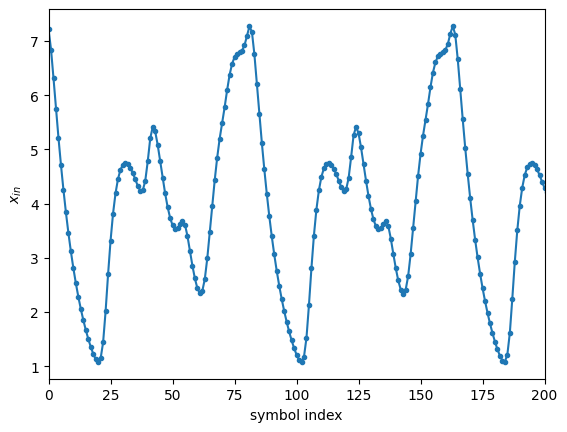

In [44]:
plt.plot(mg_dataset.u, '-o', markersize=3)
plt.xlabel('symbol index')
plt.ylabel('$x_{in}$')
plt.xlim(0, 200)
plt.show()

Then, we process this dataset through the reservoir system.
The final dataset will contain the input signal $x_{in}$, the signal vector at the detector after propagation through the reservoir system $y_{reservoir}$ and the required prediction of the next signal $y$:

In [45]:
class ReservoirResponseDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset: MGDataset,
        reservoir_system: ReservoirSystem
    ):
        self.xy = []
        
        for i in tqdm.tqdm(range(len(dataset))):
            x, y = dataset[i]
            y_reservoir = reservoir_system(x)
            self.xy.append((x, y_reservoir, y))

    def __len__(self):
        return len(self.xy)

    def __getitem__(self, idx):
        return self.xy[idx]

In [46]:
reservoir_system = ReservoirSystem(
    sim_params,
    reservoir,
    detector,
    mask=torch.tensor([1., 0.8,])
)

train_dataset = ReservoirResponseDataset(
    mg_dataset,
    reservoir_system
)

100%|██████████| 200/200 [00:25<00:00,  7.87it/s]


# Neural network

After the reservoir system with a detector, the linear output layer is applied.
The weights of this layer will be trained during the training process.
The resulting neural network is as follows:

In [47]:
class Net(torch.nn.Module):
    def __init__(self, simulation_parameters: SimulationParameters) -> None:
        super().__init__()
        self.linear_layer = torch.nn.Linear(
            in_features=simulation_parameters.axes_size('W')[0] * simulation_parameters.axes_size('H')[0],
            out_features=1
        )

    def forward(self, x):
        return self.linear_layer(x).squeeze()

In [48]:
torch.manual_seed(25)

net = Net(
    sim_params
)

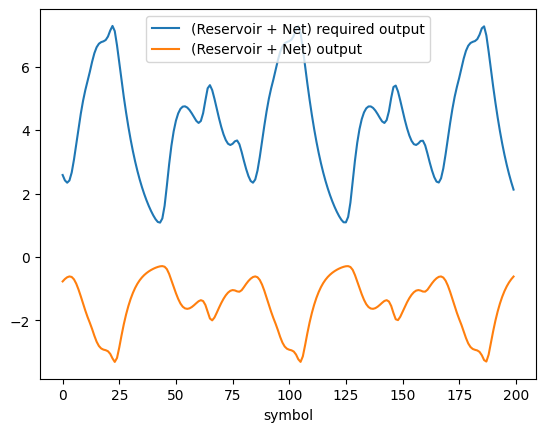

In [49]:
with torch.no_grad():
    x, y_reservoir, y = train_dataset[40]
    plt.plot(y[MG_X_PREHEAT_NUM:], label='(Reservoir + Net) required output')
    plt.plot(net(y_reservoir)[MG_X_PREHEAT_NUM:].numpy(force=True), label='(Reservoir + Net) output')

plt.xlabel('symbol')
plt.legend()

# Training

Some default training routines

In [50]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.AdamW(
    params=net.parameters(),
    lr=2e-2,
)

loss_func = torch.nn.MSELoss()

epoch_train_losses = []

In [51]:
n_epochs = 100
for epoch in tqdm.tqdm(range(n_epochs)):

    train_losses = []
    for x, y, u in train_dataloader:

        u_pred = net(y[0])
        loss = loss_func(u[0][MG_X_PREHEAT_NUM:], u_pred[MG_X_PREHEAT_NUM:])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())

    epoch_train_losses.append(torch.mean(torch.tensor(train_losses)).item())
    if epoch % 10 == 0:
        print(f'Epoch #{epoch} mean loss:', epoch_train_losses[-1])

  9%|▉         | 9/100 [00:00<00:02, 41.00it/s]

Epoch #0 mean loss: 1.4420512914657593
Epoch #10 mean loss: 0.12267999351024628


 27%|██▋       | 27/100 [00:00<00:01, 49.60it/s]

Epoch #20 mean loss: 0.11480734497308731
Epoch #30 mean loss: 0.10821171849966049


 50%|█████     | 50/100 [00:01<00:00, 50.17it/s]

Epoch #40 mean loss: 0.10631066560745239
Epoch #50 mean loss: 0.10427819192409515


 68%|██████▊   | 68/100 [00:01<00:00, 50.70it/s]

Epoch #60 mean loss: 0.10449296981096268
Epoch #70 mean loss: 0.10347328335046768


 90%|█████████ | 90/100 [00:01<00:00, 48.50it/s]

Epoch #80 mean loss: 0.10367363691329956
Epoch #90 mean loss: 0.1031264141201973


100%|██████████| 100/100 [00:02<00:00, 48.25it/s]


Evaluation

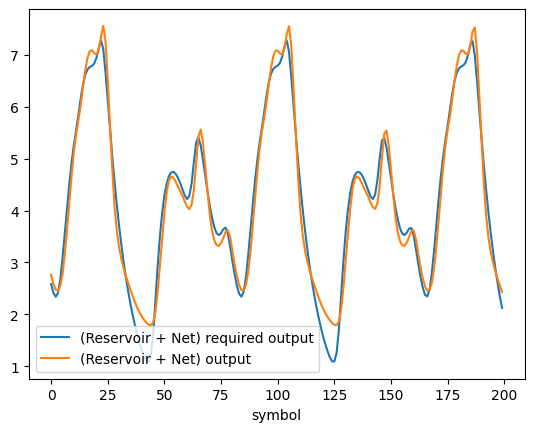

In [52]:
with torch.no_grad():
    x, y_reservoir, y = train_dataset[40]
    plt.plot(y[MG_X_PREHEAT_NUM:], label='(Reservoir + Net) required output')
    plt.plot(net(y_reservoir)[MG_X_PREHEAT_NUM:].numpy(force=True), label='(Reservoir + Net) output')

plt.xlabel('symbol')
plt.legend()